Import all libraries necesaries:

In [2]:
import cv2
from utils import vis
from model import HRpose
from skimage import io 
import numpy as np
import torchvision.transforms as transforms
import torch 
import utils.utils_ds as ut_ds
import utils.utils as ut
from core.inference import get_max_preds
import matplotlib.pyplot as plt
import math
import matplotlib.lines 

Constant variables and data necesarrias:

In [3]:
flip_pairs = [(2, 3), (1, 4), (0, 5), (8, 9), (7, 10), (6, 11)]
kps_lines=[(12, 13), (12, 8), (8, 7), (7, 6), (12, 9), (9, 10), (10, 11), (2, 1), (1, 0), (3, 4), (4, 5)]
joints_name = [
    "R_Ankle", "R_Knee", "R_Hip", "L_Hip", "L_Knee", "L_Ankle", "R_Wrist", "R_Elbow", "R_Shoulder", "L_Shoulder",
    "L_Elbow", "L_Wrist", "Thorax", "Head"]  # max std joints, first joint_num_ori will be true labeled    #, "Pelvis", "Torso", "Neck"
dict_sizes={
			'RGB': [576, 1024],
			'IR': [120, 160],
		}
dict_means={
			'RGB': [0.3875689, 0.39156103, 0.37614644],
			'IR': [0.1924838],
		}
dict_stds = {
			'RGB': [0.21462509, 0.22602762, 0.21271782],
			'IR': [0.077975444],
		}

All functions necessary for inference (creating the skeleton): 

In [4]:
def load_model(imgtype):
    """ Loading the model trained """
    n_jt = 14
    in_ch=1
    if imgtype=='RGB':
        in_ch=3
    model = HRpose.get_pose_net(in_ch=in_ch, out_ch=n_jt)

    pthfile = '\SLP_Project\SLP-Code\output\SLP_' + imgtype + '_u12_HRpose_ts1\model_dump\\final_state.pth'
    model.load_state_dict(torch.load(pthfile))
    model.eval()#set to evaluation mode
    return model

def calculatebbox(size):
    """ Calculate the bounding box of image """
    #bounding box [a, b, c, d]
    b=0.0
    if size[1]>size[0]:
        a=-(size[1]-size[0])/2.0
        c=d=float(size[1])
    elif size[1]<size[0]:
        a=-(size[0]-size[1])/2.0
        c=d=float(size[0])
    else: 
        a=0.0
        c=d=float(size[0])
    bbox=[a,b,c,d]
    return bbox

def loadimgformat(image_path, imgtype): #input image size 576x1024
    """ Preparing the input image """
    img = io.imread(image_path)
    img = np.array(img) #numpy data 
    # print("0. input image shape: ", img.shape)
    if imgtype=='IR': #IR image after reading has 2 dimension
        img = img[..., None] #add one dimension #Not for 'RGB'  

    scale, rot, do_flip, color_scale, do_occlusion = 1.0, 0.0, False, [1.0, 1.0, 1.0], False
    bbox=calculatebbox(dict_sizes[imgtype])
    # print("1. input image shape: ", img.shape)
    img_patch, trans = ut_ds.generate_patch_image(img, bbox=bbox, do_flip=do_flip, scale=scale, rot=rot, do_occlusion=do_occlusion, input_shape=(256,256))   # ori to bb, flip first trans later

    if img_patch.ndim<3:
        img_channels = 1        # add one channel
        img_patch = img_patch[..., None]
    else:
        img_channels = img_patch.shape[2]   # the channels
    for i in range(img_channels):
        img_patch[:, :, i] = np.clip(img_patch[:, :, i] * color_scale[i], 0, 255)

    mean=dict_means[imgtype]
    std=dict_stds[imgtype]    

    trans_tch = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])
    pch_tch = trans_tch(img_patch)
    pch_tch = pch_tch.unsqueeze(0) # add batch dimension in this cas batch=1
    return pch_tch

def predict(model, img_tensor): #this img_tensor should be 4 dimension adapted to model 
    """ Predicting of keypoints of skeleton """
    with torch.no_grad():
        # print(img_tensor)
        input_flipped = img_tensor.flip(3).clone() 
        output_flipped = model(input_flipped)
        output_flipped = ut_ds.flip_back(output_flipped.cpu().numpy(), flip_pairs)
        output_flipped = torch.from_numpy(output_flipped.copy()) # N x n_jt xh x w tch #.copy()).cuda()
        
        output_flipped[:, :, :, 1:] = output_flipped.clone()[:, :, :, 0:-1]
        
        # print("output flipped: ", output_flipped)
        output = model(img_tensor)
        # print("output: ", output)
        output = (output + output_flipped) * 0.5
        # print("output final: ", output)
    return output, output_flipped

def predAndPrintImg(path, savedimgname,imgtype):
    """ This function reading the model and do the inference. 
    Later print the skeleton with the image original. """

    # model=load_model('RGB')
    model=load_model(imgtype)
    # inputimage='\SLP_Project\SLP-Code\image_000001.png'
    inputimage=path
    # inputimage='\SLP_Project\SLP-Code\image_000005.png'
    # inputimage='\SLP_Project\SLP_dataset\SLP\danaLab\\00020\RGB\\uncover\image_000042.png'
    # pred, input_tensor = predict(model,inputimage)
    img = loadimgformat(inputimage,imgtype)#img type tensor 4 dimension (1,3,256,256)
    # img = loadimgformatSimlab(inputimage)#img type tensor 4 dimension (1,3,256,256)
    pred, _ = predict(model, img) #pred type tensor 4 dimension (1,14,64,64)
    
    landmark = pred.cpu().numpy() # landmark type numpy 4 dimension (1,14,64,64)
    pred, _ = get_max_preds(landmark)#pred type numpy 3 dimension (1,14,2)
    
    # print(pred[0,:,0]*256/64-56)
    # print(pred[0,:,1]*256/64)
    pred2d_patch = np.ones((14, 3))
    pred2d_patch[:,:2] = pred / 64 * 256 
    # print(pred2d_patch) #print points of joints 
    # print("ATTENTION: ", pred2d_patch)
    mean=dict_means[imgtype]
    std=dict_stds[imgtype]

    #preparing the the input image for vis_keypoints function
    img_patch_vis = ut.ts2cv2(img[0], mean, std)#img_patch_vis type numpy 3 dimension (256,256,3)
   
    #add color map for IR image
    if imgtype == 'IR':
        img_patch_vis_color = cv2.applyColorMap(img_patch_vis, cv2.COLORMAP_HOT)
        # img_patch_vis = cv2.applyColorMap(img_patch_vis, cv2.dct_clrMap[imgtype])    
        tmpimgcolor = vis.vis_keypoints(img_patch_vis_color, pred2d_patch, kps_lines)
        cv2.namedWindow("output IR color", cv2.WINDOW_NORMAL) 
        cv2.imshow("output IR color", tmpimgcolor)
    
    tmpimg = vis.vis_keypoints(img_patch_vis, pred2d_patch, kps_lines)
    # Create window with freedom of dimensions
    cv2.namedWindow("output "+imgtype, cv2.WINDOW_NORMAL) 
    # Using cv2.imshow() method
    # Displaying the image
    cv2.imshow("output "+imgtype, tmpimg)

    # waits for user to press any key
    # (this is necessary to avoid Python kernel form crashing)
    cv2.waitKey(0)
    # closing all open windows
    cv2.destroyAllWindows()
    #cv2.imwrite(f'{savedimgname}.png', tmpimg) #save the image 

    return img_patch_vis, pred2d_patch, tmpimg

def genDict(predictjoints):
    """  Creating diccionary of joints obtained after the inference"""
    dict_joints={}
    #initialate the diccionary with list 'joints_name' only keys
    for i in range(14): 
        dict_joints[joints_name[i]]=predictjoints[i]
    return dict_joints

Basics functions (mathematics) for estimation of the pin-points:

In [5]:
def calculate_distance(p1, p2):
    """ Calculate distance between two pionts"""
    # distance = math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    distance = ((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)**0.5
    return distance

def create_line(p1,p2):
    """ Create the line with two pionts (through)"""
    x1=p1[0] 
    x2=p2[0]
    y1=p1[1]
    y2=p2[1] 
    
    if (x2-x1)!=0:
        slope = (y2 - y1) / (x2 - x1) #slope
        intercept = y1 - slope * x1 #intercept  
        xt=np.linspace(0, 255, 2)
        yt=slope*xt + intercept
    else:
        slope=0
        intercept = 0 #intercept 
        xt=np.array([x1, x1])
        yt = np.linspace(0, 255, 2)

    # plt.plot(xt, yt, 'r-')  # 'r-' for a red line
    return xt, yt, slope, intercept 

def distance_point_line(p, slope, intercept, threshold=0.0):
    """ Calculate the distance between a point and a line """
    x=p[0] 
    y=p[1]
    # Apply the formula to calculate the distance abs(y-ax-b=0)/sqrt((-a)**2+(1)**2)
    A = -slope 
    B = 1
    C = -intercept     
    distance = (A*x + B*y + C) / math.sqrt(A**2 + B**2) # distance = (A * x + B * y + C) / ((A ** 2 + B ** 2) ** 0.5)

    if distance > 0: 
        if slope > 0:  point_position = 0 #Left side of the linea 
        else: point_position = 1    
    elif distance < 0: 
        if slope > 0: point_position = 1 #Right side of the linea   
        else:  point_position = 0 
    else: 
        point_position = 2 #On the linea

    distance = abs(distance) 
    return distance, point_position

def distance_point_line_noSlope(p, xref, threshold=0.0):
    """ Calculate the distance between a point and a line when slope is not defined. 
    It means the line is parallel to the y-axis """
    x=p[0]   
    distance = x - xref
    if distance < 0: 
        point_position = 0 #left side of the linea
    elif distance > 0: 
        point_position = 1 #Right side of the linea
    else: 
        point_position = 2 #On the linea
     
    distance = abs(distance)
    return distance, point_position

def is_point_in_circle(point, center, radius): 
    """ Function to check if one point is inside of an circle. 
    Here radius could be a threshold depending of person 
    (could be greeter or not) """    
    x=point[0]
    y=point[1]
    center_x=center[0]
    center_y=center[1]

    distance = math.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    return distance <= radius ##return True or False

def points_axis_center(dict_joints):
    """ Create the center points of shouder and hip. 
    (using for creating a center axis of human body) """
    d_s= (dict_joints['L_Shoulder'] + dict_joints['R_Shoulder']) / 2
    d_h= (dict_joints['L_Hip'] + dict_joints['R_Hip']) / 2
    return d_s, d_h

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    """ Calculate angle between two lines """
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else:  
        return ang_deg

Function for estimation:

In [6]:
def position_prediction(dict_joints): ###more than just prediction position of part inferior of body 
    """ Create a center axis of bady and predict the position """
    cnt_r=0
    cnt_l=0
    p1, p2 = points_axis_center(dict_joints)
    xt, yt, slope, intercept = create_line(p1,p2) ##when slope, intercept ==0, also need to implement another function
        
    if (p2[0]-p1[0])!=0:
        distance, point_position_R_Elbow = distance_point_line(dict_joints['R_Elbow'], slope, intercept, threshold=0.0)
        distance, point_position_L_Elbow = distance_point_line(dict_joints['L_Elbow'], slope, intercept, threshold=0.0)
        distance, point_position_R_Knee = distance_point_line(dict_joints['R_Knee'], slope, intercept, threshold=0.0)
        distance, point_position_L_Knee = distance_point_line(dict_joints['L_Knee'], slope, intercept, threshold=0.0)
    else:
        distance, point_position_R_Elbow = distance_point_line_noSlope(dict_joints['R_Elbow'], p1[0], threshold=0.0)
        distance, point_position_L_Elbow = distance_point_line_noSlope(dict_joints['L_Elbow'], p1[0], threshold=0.0)
        distance, point_position_R_Knee = distance_point_line_noSlope(dict_joints['R_Knee'], p1[0], threshold=0.0)
        distance, point_position_L_Knee = distance_point_line_noSlope(dict_joints['L_Knee'], p1[0], threshold=0.0)
    #----------------R_Elbow--------------       
    if (point_position_R_Elbow==0): cnt_l +=1
    elif(point_position_R_Elbow==1): cnt_r +=1
    else: 
        cnt_l=cnt_l
        cnt_r=cnt_r
    #----------------L_Elbow-------------- 
    if (point_position_L_Elbow==0): cnt_l +=1
    elif(point_position_L_Elbow==1): cnt_r +=1
    else: 
        cnt_l=cnt_l
        cnt_r=cnt_r
    #----------------R_Knee-------------- 
    if (point_position_R_Knee==0): cnt_l +=1
    elif(point_position_R_Knee==1): cnt_r +=1
    else: 
        cnt_l=cnt_l
        cnt_r=cnt_r
    #----------------L_Knee-------------- 
    if (point_position_L_Knee==0): cnt_l +=1
    elif(point_position_L_Knee==1): cnt_r +=1
    else: 
        cnt_l=cnt_l
        cnt_r=cnt_r


    cnt =  cnt_l - cnt_r
    # print("contador position: ",cnt)
    position=0
    if cnt>0: 
        position=0
        # print('left side on picture (right side on person)')
    elif cnt<0: 
        position=1
        # print('right side on picture (left side on person)')
    else: 
        position=2
        # print("Probably supina on picture")
    return xt, yt, position 

Functions check presure of points:

In [7]:
""" Functions for RGB image """
def zona_cabezal(dict_joints, position):
    #------------------OCCIPITAL, RIGHT EAR and LEFT EAR -------------------------
    pm=(dict_joints["Thorax"] + dict_joints["Head"]) /2
    pm[2]=0
    dict_joints["Occipital"]=pm.copy() 
    dict_joints["L_Ear"]=pm.copy()
    dict_joints["R_Ear"]=pm.copy()

    if position==0: #on picture is left side lying, on person is right side lying (pressure on right side)
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0
        dict_joints["R_Ear"][2]=1
    elif position==1: #creating point r_ear
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0
        dict_joints["L_Ear"][2]=1
    else:#creating point occipital
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0   
        dict_joints["Occipital"][2]=1 
    # print(dict_joints["Occipital"],  dict_joints["R_Ear"], dict_joints["L_Ear"])
    return dict_joints

def zona_superior_cuerpo(dict_joints, position):
    #------------------SHOULDER and HIP -------------------------
    dshoulder=calculate_distance(dict_joints['R_Shoulder'], dict_joints['L_Shoulder'])
    dhip=calculate_distance(dict_joints['R_Hip'], dict_joints["L_Hip"])
    # print("Shoulder distance: ", dshoulder) #posar el threshold=20
    # print("Hip distance: ", dhip)#posar threshold =19
    
    ###the threshold alway depending of person (are different to everyone)
    if dshoulder>21:
        dict_joints['L_Shoulder'][2]=1
        dict_joints['R_Shoulder'][2]=1
    else: 
        if position==0:
            dict_joints['L_Shoulder'][2]=0
            dict_joints['R_Shoulder'][2]=1
        elif position==1:
            dict_joints['R_Shoulder'][2]=0
            dict_joints['L_Shoulder'][2]=1
        else:
            dict_joints['L_Shoulder'][2]=dict_joints['L_Shoulder'][2]
            dict_joints['R_Shoulder'][2]=dict_joints['R_Shoulder'][2]

    if dhip > 19:
        dict_joints['L_Hip'][2]=1
        dict_joints['R_Hip'][2]=1
    else: 
        if position==0: #left side on the picture
            dict_joints['R_Hip'][2]=1
            dict_joints['L_Hip'][2]=0
        elif position==1:
            dict_joints['L_Hip'][2]=1
            dict_joints['R_Hip'][2]=0
        else:
            dict_joints['L_Hip'][2]=dict_joints['L_Hip'][2]
            dict_joints['R_Hip'][2]=dict_joints['R_Hip'][2]
    #-------------------------------------------------------------------------------------
    
    #-----------------------------ELBOW and WRIST ------------in this cas not including the position Prone lying----------------------------
    #---Calculate necesaries--- 
    if (dict_joints['L_Shoulder'][0]-dict_joints['L_Hip'][0])!=0:
        xt, yt, slope, intercept = create_line(dict_joints['L_Shoulder'],dict_joints['L_Hip']) ##when slope, intercept ==0, also need to implement another function
        distance_l_elbow, point_position_L_Elbow = distance_point_line(dict_joints['L_Elbow'], slope, intercept, threshold=0.0)
        distance_l_wrist, point_position_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slope, intercept, threshold=0.0) 
        dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line(dict_joints['R_Wrist'], slope, intercept, threshold=0.0)
    else:
        distance_l_elbow, point_position_L_Elbow = distance_point_line_noSlope(dict_joints['L_Elbow'], dict_joints['L_Shoulder'][0], threshold=0.0)
        distance_l_wrist, point_position_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
        dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
    # -------------------------

    if (dict_joints['R_Shoulder'][0]-dict_joints['R_Hip'][0])!=0:
        xt, yt, slope1, intercept1 = create_line(dict_joints['R_Shoulder'],dict_joints['R_Hip']) ##when slope, intercept ==0, also need to implement another function
        distance_r_elbow, point_position_R_Elbow = distance_point_line(dict_joints['R_Elbow'], slope1, intercept1, threshold=0.0)
        distance_r_wrist, point_position_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slope1, intercept1, threshold=0.0)
        dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line(dict_joints['L_Wrist'], slope1, intercept1, threshold=0.0)
    else:
        distance_r_elbow, point_position_R_Elbow = distance_point_line_noSlope(dict_joints['R_Elbow'], dict_joints['R_Shoulder'][0], threshold=0.0)
        distance_r_wrist, point_position_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)
        dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)

    # print("Relation about L_Elbow with the line: ", point_position_L_Elbow)
    # print("Relation about L_Wrist with the line: ", point_position_L_Wrist)
    # print("Relation about R_Elbow with the line: ", point_position_R_Elbow)
    # print("Relation about R_Wrist with the line: ", point_position_R_Wrist)

    if (dict_joints['Head'][0]-dict_joints['L_Shoulder'][0])!=0:
        xt, yt, slope2, intercept2 = create_line(dict_joints['Head'],dict_joints['L_Shoulder']) ##when slope, intercept ==0, also need to implement another function
        # plt.plot(xt,yt)
        dist_l_w, position_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slope2, intercept2, threshold=0.0)
        dist_l_e, position_L_Elbow = distance_point_line(dict_joints['L_Elbow'], slope2, intercept2, threshold=0.0)
    else:
        dist_l_w, position_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
        dist_l_e, position_L_Elbow = distance_point_line_noSlope(dict_joints['L_Elbow'], dict_joints['L_Shoulder'][0], threshold=0.0)
    
    if (dict_joints['Head'][0]-dict_joints['R_Shoulder'][0])!=0:
        xt, yt, slope3, intercept3 = create_line(dict_joints['Head'],dict_joints['R_Shoulder']) 
        dist_r_w, position_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slope3, intercept3, threshold=0.0)
        dist_r_e, position_R_Elbow = distance_point_line(dict_joints['R_Elbow'], slope3, intercept3, threshold=0.0)
    else:
        dist_r_w, position_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)
        dist_r_e, position_R_Elbow = distance_point_line_noSlope(dict_joints['R_Elbow'], dict_joints['R_Shoulder'][0], threshold=0.0)

    #---Cheking R_Elbow and L_Elbow---
    #-----------R_Elbow----------------------
    if (dict_joints["R_Elbow"][1]>dict_joints["R_Shoulder"][1]):
        if (point_position_R_Elbow==0) and (distance_r_elbow>7): 
            dict_joints["R_Elbow"][2]=1
    else:
        if (point_position_R_Elbow==0):
            dict_joints["R_Elbow"][2]=1
        else:
            if(position_R_Elbow==0) and (is_point_in_circle(dict_joints['R_Elbow'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Elbow'][:2], dict_joints["R_shoulder"][:2], 7)==False):
                dict_joints["R_Elbow"][2]=1
   
    #-----------L_Elbow----------------------
    if (dict_joints["L_Elbow"][1]>dict_joints["L_Shoulder"][1]):
        if (point_position_L_Elbow==1) and (distance_l_elbow>7): 
            dict_joints["L_Elbow"][2]=1
    else:
        if (point_position_L_Elbow==1):
            dict_joints["L_Elbow"][2]=1
        else:
            if(position_L_Elbow==1) and (is_point_in_circle(dict_joints['L_Elbow'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Elbow'][:2], dict_joints["L_shoulder"][:2], 7)==False):
                dict_joints["L_Elbow"][2]=1

    # #-----------R_Wrist----------------------
    # dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line(dict_joints['R_Wrist'], slope, intercept, threshold=0.0)
    if (dict_joints["R_Wrist"][1] > dict_joints["R_Shoulder"][1]) and (dict_joints["R_Wrist"][1] < dict_joints["R_Hip"][1]):
        if (point_position_R_Wrist==0) and (distance_r_wrist>7): 
            dict_joints["R_Wrist"][2]=1
        else:
            if(poipos_r_wrist_toLeftLine==1) and (dis_r_wrist_toLeftLine>7):
                dict_joints["R_Wrist"][2]=1

    elif (dict_joints["R_Wrist"][1]<=dict_joints["R_Shoulder"][1]):
        if (point_position_R_Wrist==0):
            dict_joints["R_Wrist"][2]=1
        else:
            if(position_R_Wrist==0) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["R_Shoulder"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["R_Elbow"][:2], 7)==False):
                dict_joints["R_Wrist"][2]=1
    else:
        if (dict_joints['R_Hip'][0]-dict_joints['R_Knee'][0])!=0:
            _, _, slo, inter = create_line(dict_joints['R_Hip'],dict_joints['R_Knee']) 
            d_r_w, p_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slo, inter, threshold=0.0)
        else:
            d_r_w, p_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Hip'][0], threshold=0.0)
        
        if (p_R_Wrist==0) and (d_r_w>7):
            dict_joints["R_Wrist"][2]=1
    
    # # #-----------L_Wrist----------------------
    # # dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line(dict_joints['L_Wrist'], slope1, intercept1, threshold=0.0)

    if (dict_joints["L_Wrist"][1]>dict_joints["L_Shoulder"][1]) and (dict_joints["L_Wrist"][1]<dict_joints["L_Hip"][1]):
        if (point_position_L_Wrist==0) and (distance_l_wrist>7): 
            dict_joints["L_Wrist"][2]=1
        else:
            if(poipos_l_wrist_toRightLine==1) and (dis_l_wrist_toRightLine>7):
                dict_joints["L_Wrist"][2]=1
        
    elif (dict_joints["L_Wrist"][1]<=dict_joints["L_Shoulder"][1]):
        if (point_position_L_Wrist==0):
            dict_joints["L_Wrist"][2]=1
        else:
            if(position_L_Wrist==0) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["L_shoulder"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["L_Elbow"][:2], 7)==False):
                dict_joints["L_Wrist"][2]=1
    else:
        if (dict_joints['L_Hip'][0]-dict_joints['L_Knee'][0])!=0:
            _, _, slo1, inter1 = create_line(dict_joints['L_Hip'],dict_joints['L_Knee']) 
            d_l_w, p_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slo1, inter1, threshold=0.0)
        else:
            d_l_w, p_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Hip'][0], threshold=0.0)
        
        if (p_L_Wrist==0) and (d_l_w>7):
            dict_joints["L_Wrist"][2]=1
    # print(dist_l_w, "······Relation about L_Wrist with the linea: ", position_L_Wrist)
    # print(dist_r_w, "······Relation about R_Wrist with the linea: ", position_R_Wrist)
    return dict_joints

def zona_inferior_cuerpo(dict_joints, position):
    #----------------------R_Knee and L_Knee--------------------------------------------------
    """ pinpoint right knee and left knee"""
    d1=calculate_distance(dict_joints["R_Knee"],dict_joints["L_Knee"]) 
    if d1>20: #suponemos que la distancia entre dos rodillas/el threshold=20 pixes
        dict_joints["R_Knee"][2]=1
        dict_joints["L_Knee"][2]=1
    else:
        if position==0: #left side of the line --> es pose right side
            dict_joints["R_Knee"][2]=1
            dict_joints["L_Knee"][2]=0
        elif position==1:
            dict_joints["R_Knee"][2]=0
            dict_joints["L_Knee"][2]=1
        else: ######DOUBT NOT SURE IS CORRECTLY 
            dict_joints["R_Knee"][2]=1
            dict_joints["L_Knee"][2]=1

    d2_1=calculate_distance(dict_joints["R_Knee"],dict_joints["R_Hip"])
    d2_2=calculate_distance(dict_joints["R_Knee"],dict_joints["R_Ankle"])
    if (d2_1<25) | (d2_2<25):#屈膝状态 threshold=30 no --> 25
        dict_joints["R_Knee"][2]=0

    d4_1=calculate_distance(dict_joints["L_Knee"],dict_joints["L_Hip"])
    d4_2=calculate_distance(dict_joints["L_Knee"],dict_joints["L_Ankle"])
    if (d4_1<25) | (d4_2<25):#屈膝状态 threshould=30 
        dict_joints["L_Knee"][2]=0
    #-------------------------------------------------------------------------------------

    #-----------------------R_Ankle and L_Ankle-------------------------------------------
    """ pinpoint right ankle and left ankle """
    d3=calculate_distance(dict_joints["R_Ankle"],dict_joints["L_Ankle"])
    if d3>20: 
        dict_joints["R_Ankle"][2]=1
        dict_joints["L_Ankle"][2]=1
    else:
        if position==0:
            dict_joints["R_Ankle"][2]=1
            dict_joints["L_Ankle"][2]=0
        elif position==1:
            dict_joints["R_Ankle"][2]=0
            dict_joints["L_Ankle"][2]=1
        else:
            dict_joints["R_Ankle"][2]=1
            dict_joints["L_Ankle"][2]=1
            # dict_joints["R_Ankle"][2]=dict_joints["R_Ankle"][2]
            # dict_joints["L_Ankle"][2]=dict_joints["L_Ankle"][2]
    
    #if r_ankle and l_ankle ==1 check:
    d2=calculate_distance(dict_joints["R_Knee"],dict_joints["L_Ankle"])
    if d2<20:
        if position==0:
            dict_joints["L_Ankle"][2]=0
    d4=calculate_distance(dict_joints["L_Knee"],dict_joints["R_Ankle"])
    if d4<20:
        if position==1:
            dict_joints["R_Ankle"][2]=0

    #if r_ankle and l_ankle ==1 check:
    #check distance between line(r_hip and r_knee) with L_ankle. and line(r_ankle and r_knee) with l_ankle
    xt, yt, slope, intercept = create_line(dict_joints['R_Hip'],dict_joints['R_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance, point_position_L_Elbow = distance_point_line(dict_joints['L_Ankle'], slope, intercept, threshold=0.0)
    # print("diatancia left leg:" ,distance)
    if distance < 16:#
        if position==0:
            dict_joints["L_Ankle"][2]=0

    xt, yt, slope1, intercept1 = create_line(dict_joints['R_Ankle'],dict_joints['R_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance1, point_position_L_Elbow = distance_point_line(dict_joints['L_Ankle'], slope1, intercept1, threshold=0.0)
    if distance1 < 16:
        if position==0:
            dict_joints["L_Ankle"][2]=0


    #check distance between line(l_hip and l_knee) with r_ankle. and line(l_ankle and l_knee) with r_ankle
    xt, yt, slope, intercept = create_line(dict_joints['L_Hip'],dict_joints['L_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance, point_position_L_Elbow = distance_point_line(dict_joints['R_Ankle'], slope, intercept, threshold=0.0)
    # print("diatancia:" ,distance)
    # print("dict_joints[R_Ankle][1]: ",dict_joints["R_Ankle"][1])
    # print("dict_joints[L_Knee][1]: ",dict_joints["L_Knee"][1])
    # print("dict_joints[L_Hip][1]: ",dict_joints["L_Hip"][1])
    if distance < 16:#20
        if position==1:
            dict_joints["R_Ankle"][2]=0
        if position==2 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Hip"][1]: ##because the axis y plot (255,0)
            dict_joints["R_Ankle"][2]=0
    # print("dict_joints[R_Ankle][1]: ",dict_joints["R_Ankle"][2])
    # print("dict_joints[L_Ankle][1]: ",dict_joints["L_Ankle"][2])
    xt, yt, slope1, intercept1 = create_line(dict_joints['L_Ankle'],dict_joints['L_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance1, point_position_L_Elbow = distance_point_line(dict_joints['R_Ankle'], slope1, intercept1, threshold=0.0)
    if distance1 < 16:
        # if position==1:
        if position==1 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Ankle"][1]:
            dict_joints["R_Ankle"][2]=0
        if position==2 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Ankle"][1]:
            dict_joints["R_Ankle"][2]=0
    
    """ ----------------check the part L_CalfMucle and R_CalfMucle----------------"""
    #calculate angle between two lines
    lineA1=[dict_joints['L_Knee'], dict_joints['L_Ankle']]
    lineB1=[dict_joints['L_Knee'], dict_joints['L_Hip']]
    leftAngle=ang(lineA1, lineB1)
    # print("Left angle: ",leftAngle)
    # print("Left angle: ",ang(lineA, lineB))
    lineA2=[dict_joints['R_Knee'], dict_joints['R_Ankle']]
    lineB2=[dict_joints['R_Knee'], dict_joints['R_Hip']]
    rightAngle=ang(lineA2, lineB2)
    # print("Right angle: ",rightAngle)

    # print(dict_joints["R_Ankle"][2], dict_joints["R_Knee"][2], position)
    # print(dict_joints["L_Ankle"][2], dict_joints["L_Knee"][2])
    
    #----check----- 
    if dict_joints["R_Ankle"][2]==1 and dict_joints["R_Knee"][2]==1 and position==2 and rightAngle>166:
        pm1=(dict_joints["R_Ankle"] + dict_joints["R_Knee"]) /2
        pm1[2]=0
        dict_joints["R_CalfMucle"]=pm1.copy()
        dict_joints["R_CalfMucle"][2]=1
        dict_joints["R_Ankle"][2]=0
        dict_joints["R_Knee"][2]=0

    if dict_joints["L_Ankle"][2]==1 and dict_joints["L_Knee"][2]==1 and position==2 and leftAngle>166:
        pm2=(dict_joints["L_Ankle"] + dict_joints["L_Knee"]) /2
        pm2[2]=0
        dict_joints["L_CalfMucle"]=pm2.copy()
        dict_joints["L_CalfMucle"][2]=1
        dict_joints["L_Ankle"][2]=0
        dict_joints["L_Knee"][2]=0
        
    return dict_joints

Function for IR imagen (The difference is the threshold): 

In [18]:
def zona_cabezal_IR(dict_joints, position):
    #------------------OCCIPITAL, RIGHT EAR and LEFT EAR -------------------------
    pm=(dict_joints["Thorax"] + dict_joints["Head"]) /2
    pm[2]=0
    dict_joints["Occipital"]=pm.copy() 
    dict_joints["L_Ear"]=pm.copy()
    dict_joints["R_Ear"]=pm.copy()

    if position==0: #on picture is left side lying, on person is right side lying (pressure on right side)
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0
        dict_joints["R_Ear"][2]=1
    elif position==1: #creating point r_ear
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0
        dict_joints["L_Ear"][2]=1
    else:#creating point occipital
        dict_joints['Head'][2]=0
        dict_joints['Thorax'][2]=0   
        dict_joints["Occipital"][2]=1 
    # print(dict_joints["Occipital"],  dict_joints["R_Ear"], dict_joints["L_Ear"])
    return dict_joints

def zona_superior_cuerpo_IR(dict_joints, position):
    #------------------SHOULDER and HIP -------------------------
    if position == 2:
        dict_joints['L_Hip'][2]=1
        dict_joints['R_Hip'][2]=1
        dict_joints['L_Shoulder'][2]=1
        dict_joints['R_Shoulder'][2]=1
    elif position == 0:
        dict_joints['L_Hip'][2]=0
        dict_joints['R_Hip'][2]=1
        dict_joints['L_Shoulder'][2]=0
        dict_joints['R_Shoulder'][2]=1
    elif position == 1:
        dict_joints['L_Hip'][2]=1
        dict_joints['R_Hip'][2]=0
        dict_joints['L_Shoulder'][2]=1
        dict_joints['R_Shoulder'][2]=0

    # dshoulder=calculate_distance(dict_joints['R_Shoulder'], dict_joints['L_Shoulder'])
    # dhip=calculate_distance(dict_joints['R_Hip'], dict_joints["L_Hip"])
    # # print("Shoulder distance: ", dshoulder) #posar el threshold=20
    # # print("Hip distance: ", dhip)#posar threshold =19
    
    # ###the threshold alway depending of person (are different to everyone)
    # if dshoulder>44:
    #     dict_joints['L_Shoulder'][2]=1
    #     dict_joints['R_Shoulder'][2]=1
    # else: 
    #     if position==0:
    #         dict_joints['L_Shoulder'][2]=0
    #         dict_joints['R_Shoulder'][2]=1
    #     elif position==1:
    #         dict_joints['R_Shoulder'][2]=0
    #         dict_joints['L_Shoulder'][2]=1
    #     else:
    #         dict_joints['L_Shoulder'][2]=dict_joints['L_Shoulder'][2]
    #         dict_joints['R_Shoulder'][2]=dict_joints['R_Shoulder'][2]

    # if dhip > 31:
    #     dict_joints['L_Hip'][2]=1
    #     dict_joints['R_Hip'][2]=1
    # else: 
    #     if position==0: #left side on the picture
    #         dict_joints['R_Hip'][2]=1
    #         dict_joints['L_Hip'][2]=0
    #     elif position==1:
    #         dict_joints['L_Hip'][2]=1
    #         dict_joints['R_Hip'][2]=0
    #     else:
    #         dict_joints['L_Hip'][2]=dict_joints['L_Hip'][2]
    #         dict_joints['R_Hip'][2]=dict_joints['R_Hip'][2]
    #-------------------------------------------------------------------------------------
    
    
    #-----------------------------ELBOW and WRIST ------------in this cas not including the position Prone lying----------------------------
    #---Calculate necessaries--- 
    if (dict_joints['L_Shoulder'][0]-dict_joints['L_Hip'][0])!=0:
        xt, yt, slope, intercept = create_line(dict_joints['L_Shoulder'],dict_joints['L_Hip']) ##when slope, intercept ==0, also need to implement another function
        distance_l_elbow, point_position_L_Elbow = distance_point_line(dict_joints['L_Elbow'], slope, intercept, threshold=0.0)
        distance_l_wrist, point_position_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slope, intercept, threshold=0.0) 
        dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line(dict_joints['R_Wrist'], slope, intercept, threshold=0.0)
    else:
        distance_l_elbow, point_position_L_Elbow = distance_point_line_noSlope(dict_joints['L_Elbow'], dict_joints['L_Shoulder'][0], threshold=0.0)
        distance_l_wrist, point_position_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
        dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
    # -------------------------

    if (dict_joints['R_Shoulder'][0]-dict_joints['R_Hip'][0])!=0:
        xt, yt, slope1, intercept1 = create_line(dict_joints['R_Shoulder'],dict_joints['R_Hip']) ##when slope, intercept ==0, also need to implement another function
        distance_r_elbow, point_position_R_Elbow = distance_point_line(dict_joints['R_Elbow'], slope1, intercept1, threshold=0.0)
        distance_r_wrist, point_position_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slope1, intercept1, threshold=0.0)
        dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line(dict_joints['L_Wrist'], slope1, intercept1, threshold=0.0)
    else:
        distance_r_elbow, point_position_R_Elbow = distance_point_line_noSlope(dict_joints['R_Elbow'], dict_joints['R_Shoulder'][0], threshold=0.0)
        distance_r_wrist, point_position_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)
        dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)

    # print("Relation about L_Elbow with the line: ", point_position_L_Elbow)
    # print("Relation about L_Wrist with the line: ", point_position_L_Wrist)
    # print("Relation about R_Elbow with the line: ", point_position_R_Elbow)
    # print("Relation about R_Wrist with the line: ", point_position_R_Wrist)

    if (dict_joints['Head'][0]-dict_joints['L_Shoulder'][0])!=0:
        xt, yt, slope2, intercept2 = create_line(dict_joints['Head'],dict_joints['L_Shoulder']) ##when slope, intercept ==0, also need to implement another function
        # plt.plot(xt,yt)
        dist_l_w, position_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slope2, intercept2, threshold=0.0)
        dist_l_e, position_L_Elbow = distance_point_line(dict_joints['L_Elbow'], slope2, intercept2, threshold=0.0)
    else:
        dist_l_w, position_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Shoulder'][0], threshold=0.0)
        dist_l_e, position_L_Elbow = distance_point_line_noSlope(dict_joints['L_Elbow'], dict_joints['L_Shoulder'][0], threshold=0.0)
    
    if (dict_joints['Head'][0]-dict_joints['R_Shoulder'][0])!=0:
        xt, yt, slope3, intercept3 = create_line(dict_joints['Head'],dict_joints['R_Shoulder']) 
        dist_r_w, position_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slope3, intercept3, threshold=0.0)
        dist_r_e, position_R_Elbow = distance_point_line(dict_joints['R_Elbow'], slope3, intercept3, threshold=0.0)
    else:
        dist_r_w, position_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Shoulder'][0], threshold=0.0)
        dist_r_e, position_R_Elbow = distance_point_line_noSlope(dict_joints['R_Elbow'], dict_joints['R_Shoulder'][0], threshold=0.0)

    #---Cheking R_Elbow and L_Elbow---
    #-----------R_Elbow----------------------
    if (dict_joints["R_Elbow"][1]>dict_joints["R_Shoulder"][1]):
        if (point_position_R_Elbow==0) and (distance_r_elbow>7): 
            dict_joints["R_Elbow"][2]=1
    else:
        if (point_position_R_Elbow==0):
            dict_joints["R_Elbow"][2]=1
        else:
            if(position_R_Elbow==0) and (is_point_in_circle(dict_joints['R_Elbow'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Elbow'][:2], dict_joints["R_shoulder"][:2], 7)==False):
                dict_joints["R_Elbow"][2]=1
   
    #-----------L_Elbow----------------------
    if (dict_joints["L_Elbow"][1]>dict_joints["L_Shoulder"][1]):
        if (point_position_L_Elbow==1) and (distance_l_elbow>7): 
            dict_joints["L_Elbow"][2]=1
    else:
        if (point_position_L_Elbow==1):
            dict_joints["L_Elbow"][2]=1
        else:
            if(position_L_Elbow==1) and (is_point_in_circle(dict_joints['L_Elbow'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Elbow'][:2], dict_joints["L_shoulder"][:2], 7)==False):
                dict_joints["L_Elbow"][2]=1


    # #-----------R_Wrist----------------------
    # dis_r_wrist_toLeftLine, poipos_r_wrist_toLeftLine = distance_point_line(dict_joints['R_Wrist'], slope, intercept, threshold=0.0)
    if (dict_joints["R_Wrist"][1] > dict_joints["R_Shoulder"][1]) and (dict_joints["R_Wrist"][1] < dict_joints["R_Hip"][1]):
        if (point_position_R_Wrist==0) and (distance_r_wrist>7): 
            dict_joints["R_Wrist"][2]=1
        else:
            if(poipos_r_wrist_toLeftLine==1) and (dis_r_wrist_toLeftLine>7):
                dict_joints["R_Wrist"][2]=1

    elif (dict_joints["R_Wrist"][1]<=dict_joints["R_Shoulder"][1]):
        if (point_position_R_Wrist==0):
            dict_joints["R_Wrist"][2]=1
        else:
            if(position_R_Wrist==0) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["R_Shoulder"][:2], 7)==False) and (is_point_in_circle(dict_joints['R_Wrist'][:2], dict_joints["R_Elbow"][:2], 7)==False):
                dict_joints["R_Wrist"][2]=1
    else:
        if (dict_joints['R_Hip'][0]-dict_joints['R_Knee'][0])!=0:
            _, _, slo, inter = create_line(dict_joints['R_Hip'],dict_joints['R_Knee']) 
            d_r_w, p_R_Wrist = distance_point_line(dict_joints['R_Wrist'], slo, inter, threshold=0.0)
        else:
            d_r_w, p_R_Wrist = distance_point_line_noSlope(dict_joints['R_Wrist'], dict_joints['R_Hip'][0], threshold=0.0)
        
        if (p_R_Wrist==0) and (d_r_w>7):
            dict_joints["R_Wrist"][2]=1
    
    # # #-----------L_Wrist----------------------
    # # dis_l_wrist_toRightLine, poipos_l_wrist_toRightLine = distance_point_line(dict_joints['L_Wrist'], slope1, intercept1, threshold=0.0)
    if (dict_joints["L_Wrist"][1]>dict_joints["L_Shoulder"][1]) and (dict_joints["L_Wrist"][1]<dict_joints["L_Hip"][1]):
        if (point_position_L_Wrist==0) and (distance_l_wrist>7): 
            dict_joints["L_Wrist"][2]=1
        else:
            if(poipos_l_wrist_toRightLine==1) and (dis_l_wrist_toRightLine>7):
                dict_joints["L_Wrist"][2]=1
        
    elif (dict_joints["L_Wrist"][1]<=dict_joints["L_Shoulder"][1]):
        if (point_position_L_Wrist==0):
            dict_joints["L_Wrist"][2]=1
        else:
            if(position_L_Wrist==0) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["Head"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["L_shoulder"][:2], 7)==False) and (is_point_in_circle(dict_joints['L_Wrist'][:2], dict_joints["L_Elbow"][:2], 7)==False):
                dict_joints["L_Wrist"][2]=1
    else:
        if (dict_joints['L_Hip'][0]-dict_joints['L_Knee'][0])!=0:
            _, _, slo1, inter1 = create_line(dict_joints['L_Hip'],dict_joints['L_Knee']) 
            d_l_w, p_L_Wrist = distance_point_line(dict_joints['L_Wrist'], slo1, inter1, threshold=0.0)
        else:
            d_l_w, p_L_Wrist = distance_point_line_noSlope(dict_joints['L_Wrist'], dict_joints['L_Hip'][0], threshold=0.0)
        
        if (p_L_Wrist==0) and (d_l_w>7):
            dict_joints["L_Wrist"][2]=1
    
    # print(dist_l_w, "······Relation about L_Wrist with the linea: ", position_L_Wrist)
    # print(dist_r_w, "······Relation about R_Wrist with the linea: ", position_R_Wrist)   
    return dict_joints

def zona_inferior_cuerpo_IR(dict_joints, position):
    #----------------------R_Knee and L_Knee--------------------------------------------------
    """ pin-point right knee and left knee"""
    d1=calculate_distance(dict_joints["R_Knee"],dict_joints["L_Knee"]) 
    if d1>20: #suponemos que la distancia entre dos rodillas/el threshold=20 pixes
        dict_joints["R_Knee"][2]=1
        dict_joints["L_Knee"][2]=1
    else:
        if position==0: #left side of the line --> es pose right side
            dict_joints["R_Knee"][2]=1
            dict_joints["L_Knee"][2]=0
        elif position==1:
            dict_joints["R_Knee"][2]=0
            dict_joints["L_Knee"][2]=1
        else: ######DOUBT NOT SURE IS CORRECTLY 
            dict_joints["R_Knee"][2]=1
            dict_joints["L_Knee"][2]=1

    d2_1=calculate_distance(dict_joints["R_Knee"],dict_joints["R_Hip"])
    d2_2=calculate_distance(dict_joints["R_Knee"],dict_joints["R_Ankle"])
    print("R_Kee a R_Hip: ", d2_1)
    print("R_Kee a R_Ankle: ", d2_2)
    if (d2_1<35) | (d2_2<35):#Bend knees perpendicular to mattress surface (threshold=30 no --> 25)
        dict_joints["R_Knee"][2]=0

    d4_1=calculate_distance(dict_joints["L_Knee"],dict_joints["L_Hip"])
    d4_2=calculate_distance(dict_joints["L_Knee"],dict_joints["L_Ankle"])
    print("L_Kee a L_Hip: ", d4_1)
    print("L_Kee a L_Ankle: ", d4_2)
    if (d4_1<35) | (d4_2<35):#Bend knees perpendicular to mattress surface ( threshould=30) 
        dict_joints["L_Knee"][2]=0
    #-------------------------------------------------------------------------------------

    #-----------------------R_Ankle and L_Ankle-------------------------------------------
    """ pinpoint right ankle and left ankle """
    d3=calculate_distance(dict_joints["R_Ankle"],dict_joints["L_Ankle"])
    if d3>20: 
        dict_joints["R_Ankle"][2]=1
        dict_joints["L_Ankle"][2]=1
    else:
        if position==0:
            dict_joints["R_Ankle"][2]=1
            dict_joints["L_Ankle"][2]=0
        elif position==1:
            dict_joints["R_Ankle"][2]=0
            dict_joints["L_Ankle"][2]=1
        else:
            dict_joints["R_Ankle"][2]=1
            dict_joints["L_Ankle"][2]=1
            # dict_joints["R_Ankle"][2]=dict_joints["R_Ankle"][2]
            # dict_joints["L_Ankle"][2]=dict_joints["L_Ankle"][2]
    
    #if r_ankle and l_ankle ==1 check:
    d2=calculate_distance(dict_joints["R_Knee"],dict_joints["L_Ankle"])
    if d2<20:
        if position==0:
            dict_joints["L_Ankle"][2]=0
    d4=calculate_distance(dict_joints["L_Knee"],dict_joints["R_Ankle"])
    if d4<20:
        if position==1:
            dict_joints["R_Ankle"][2]=0

    #if r_ankle and l_ankle ==1 check:
    #check distance between line(r_hip and r_knee) with L_ankle. and line(r_ankle and r_knee) with l_ankle
    xt, yt, slope, intercept = create_line(dict_joints['R_Hip'],dict_joints['R_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance, point_position_L_Elbow = distance_point_line(dict_joints['L_Ankle'], slope, intercept, threshold=0.0)
    # print("diatancia left leg:" ,distance)
    if distance < 16:#
        if position==0:
            dict_joints["L_Ankle"][2]=0

    xt, yt, slope1, intercept1 = create_line(dict_joints['R_Ankle'],dict_joints['R_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance1, point_position_L_Elbow = distance_point_line(dict_joints['L_Ankle'], slope1, intercept1, threshold=0.0)
    if distance1 < 16:
        if position==0:
            dict_joints["L_Ankle"][2]=0


    #check distance between line(l_hip and l_knee) with r_ankle. and line(l_ankle and l_knee) with r_ankle
    xt, yt, slope, intercept = create_line(dict_joints['L_Hip'],dict_joints['L_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance, point_position_L_Elbow = distance_point_line(dict_joints['R_Ankle'], slope, intercept, threshold=0.0)
    # print("diatancia:" ,distance)
    # print("dict_joints[R_Ankle][1]: ",dict_joints["R_Ankle"][1])
    # print("dict_joints[L_Knee][1]: ",dict_joints["L_Knee"][1])
    # print("dict_joints[L_Hip][1]: ",dict_joints["L_Hip"][1])
    if distance < 16:#20
        if position==1:
            dict_joints["R_Ankle"][2]=0
        if position==2 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Hip"][1]: ##because the axis y plot (255,0)
            dict_joints["R_Ankle"][2]=0
    # print("dict_joints[R_Ankle][1]: ",dict_joints["R_Ankle"][2])
    # print("dict_joints[L_Ankle][1]: ",dict_joints["L_Ankle"][2])
    xt, yt, slope1, intercept1 = create_line(dict_joints['L_Ankle'],dict_joints['L_Knee']) ##when slope, intercept ==0, also need to implement another function
    distance1, point_position_L_Elbow = distance_point_line(dict_joints['R_Ankle'], slope1, intercept1, threshold=0.0)
    if distance1 < 16:
        # if position==1:
        if position==1 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Ankle"][1]:
            dict_joints["R_Ankle"][2]=0
        if position==2 and dict_joints["R_Ankle"][1]<dict_joints["L_Knee"][1] and dict_joints["R_Ankle"][1]>dict_joints["L_Ankle"][1]:
            dict_joints["R_Ankle"][2]=0
    

    """ ----------------check the part L_CalfMucle and R_CalfMucle----------------"""
    #calculate angle between two lines
    lineA1=[dict_joints['L_Knee'], dict_joints['L_Ankle']]
    lineB1=[dict_joints['L_Knee'], dict_joints['L_Hip']]
    leftAngle=ang(lineA1, lineB1)
    # print("Left angle: ",leftAngle)
    # print("Left angle: ",ang(lineA, lineB))
    lineA2=[dict_joints['R_Knee'], dict_joints['R_Ankle']]
    lineB2=[dict_joints['R_Knee'], dict_joints['R_Hip']]
    rightAngle=ang(lineA2, lineB2)
    # print("Right angle: ",rightAngle)

    # print(dict_joints["R_Ankle"][2], dict_joints["R_Knee"][2], position)
    # print(dict_joints["L_Ankle"][2], dict_joints["L_Knee"][2])
    
    #----check----- 
    if dict_joints["R_Ankle"][2]==1 and dict_joints["R_Knee"][2]==1 and position==2 and rightAngle>166:
        pm1=(dict_joints["R_Ankle"] + dict_joints["R_Knee"]) /2
        pm1[2]=0
        dict_joints["R_CalfMucle"]=pm1.copy()
        dict_joints["R_CalfMucle"][2]=1
        # dict_joints["R_Ankle"][2]=0
        dict_joints["R_Knee"][2]=0

    if dict_joints["L_Ankle"][2]==1 and dict_joints["L_Knee"][2]==1 and position==2 and leftAngle>166:
        pm2=(dict_joints["L_Ankle"] + dict_joints["L_Knee"]) /2
        pm2[2]=0
        dict_joints["L_CalfMucle"]=pm2.copy()
        dict_joints["L_CalfMucle"][2]=1
        # dict_joints["L_Ankle"][2]=0
        dict_joints["L_Knee"][2]=0
   
    return dict_joints

In [9]:
#creating a plot function with the dict_joints (image, axis center, and 14 pinpoints provisional)
def plot_pinpoints(dict_joints, imgvis):
    plt.imshow(imgvis)#print the original image 
   
    xg=[]
    yg=[]
    xr=[]
    yr=[]
    for i in dict_joints.keys():
        # print(type(dict_joints[i]))
        if dict_joints[i][2]==1:
            xr.append(dict_joints[i][0])
            yr.append(dict_joints[i][1])
        else:
            xg.append(dict_joints[i][0])
            yg.append(dict_joints[i][1])
    # plt.scatter(xg, yg, color='green')
    plt.scatter(xr, yr, color='red')

    xt,yt,position=position_prediction(dict_joints)
    # plt.plot(xt, yt, 'royalblue')  # 'r-' for a red line
    
    plt.xlim([0, 255])
    plt.ylim([255, 0])
    plt.show()

    """ print results with text """
    pinpoints = []
    for i in dict_joints.keys():
        if dict_joints[i][2]==1:
            # print(i, ":", dict_joints[i])
            pinpoints.append(i)
    print("Los puntos de presión son: ")
    print(pinpoints[:6])
    print(pinpoints[6:])

#plots points of joints with radius=3.5
def plot_Circles(dict_pred, imgvis):
    plt.imshow(imgvis)#print the original image 
    xt,yt,position=position_prediction(dict_pred)
    plt.plot(xt, yt, 'royalblue')  # 'r-' for a red line
    
    x=[]
    for i in dict_pred.keys():
        x.append(plt.Circle(dict_pred[i][:2],radius=3.5,color="orange")) # #define circles and add to the list x # c1=plt.Circle((5, 5), radius=1)

    for ix in x:
        plt.gca().add_artist(ix) #add circles to plot
        
    plt.xlim([0, 255])
    plt.ylim([255, 0])
    plt.show()



Main function:

R_Kee a R_Hip:  36.22154055254967
R_Kee a R_Ankle:  36.0
L_Kee a L_Hip:  36.0
L_Kee a L_Ankle:  36.0


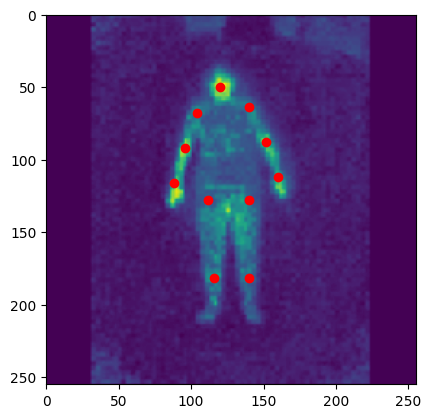

Los puntos de presión son: 
['R_Hip', 'L_Hip', 'R_Wrist', 'R_Elbow', 'R_Shoulder', 'L_Shoulder']
['L_Elbow', 'L_Wrist', 'Occipital', 'R_CalfMucle', 'L_CalfMucle']


In [19]:
# imgtype='RGB'
# #imgpath='\SLP_Project\SLP_dataset\SLP\danaLab\\00056\RGB\\uncover\image_000005.png' #000041.png #00026
# imgpath='\SLP_Project\SLP-Code\output_cmos1.jpg' #000041.png #00026

imgtype='IR' 
imgpath='\SLP_Project\SLP-Code\\grayir.jpg' 
# imgpath='\SLP_Project\SLP_dataset\SLP\danaLab\\00056\IR\\uncover\image_000035.png' #000041.png #00026

saveimgname='11' #not actived (need to uncomment some lines)    
img_ori, pred, img_vis = predAndPrintImg(imgpath,saveimgname,imgtype) #'\SLP_Project\SLP-Code\\uncover\image_000041.png','41'
imgvis = img_ori[:,:, ::-1]

dict_joints=genDict(pred)
dict_pred=genDict(pred)
# plot_Circles(dict_pred, imgvis)

#dict_joints all joints = 0 #not toching the mattress, like default 
for i in dict_joints.keys():
    dict_joints[i][2]=0   
xt,yt,position=position_prediction(dict_joints)
if (imgtype=='RGB'):
    dict_joints=zona_cabezal(dict_joints, position)
    dict_joints=zona_superior_cuerpo(dict_joints, position) 
    dict_joints=zona_inferior_cuerpo(dict_joints, position)
elif (imgtype=='IR'):
    dict_joints=zona_cabezal_IR(dict_joints, position)
    dict_joints=zona_superior_cuerpo_IR(dict_joints, position) 
    dict_joints=zona_inferior_cuerpo_IR(dict_joints, position)
# print(dict_joints)

plot_pinpoints(dict_joints, imgvis)
